# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [ ]:
# pip install distutils
# pip install sklearn
# pip install cv2

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
import os

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [5]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

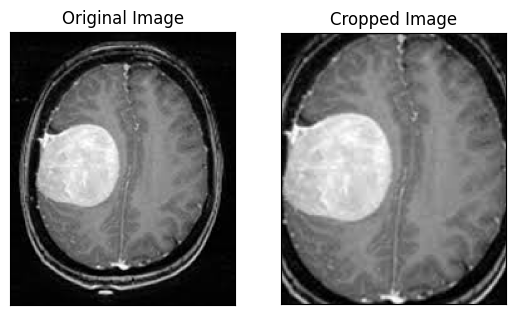

In [6]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [ ]:
# pip install os

In [ ]:
augmented_path = '/Users/akashthakkar/Desktop/Brain Tumuour/augmented data'

# Use os.path.join() to correctly join paths
augmented_yes = os.path.join(augmented_path, 'yes') 
augmented_no = os.path.join(augmented_path, 'no')

IMG_WIDTH, IMG_HEIGHT = (240, 240)

def load_data(directories, image_size):
    images = []
    labels = []
    
    for dir_path in directories:
        label = 1 if 'yes' in dir_path else 0  # Label 'yes' as 1 and 'no' as 0
        for filename in os.listdir(dir_path):
            file_path = os.path.join(dir_path, filename)
            
            # Debugging: Print the file path being processed
            print(f"Processing file: {file_path}")
            
            # Read the image
            image = cv2.imread(file_path)

            # Check if the image was loaded successfully
            if image is None:
                print(f"Warning: Failed to load image {file_path}")
                continue

            # Crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)

            # Resize the image to the desired dimensions
            image = cv2.resize(image, dsize=(image_size[0], image_size[1]), interpolation=cv2.INTER_CUBIC)

            images.append(image)
            labels.append(label)
    
    return np.array(images), np.array(labels)

def crop_brain_contour(image, plot=False):
    if image is None:
        print("Invalid image provided for cropping.")
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Threshold the image
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # Perform erosions and dilations to remove small noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if len(cnts) == 0:
        return image  # If no contours found, return the original image
    
    # Find the largest contour
    c = max(cnts, key=cv2.contourArea)
    
    # Get the bounding box of the brain
    x, y, w, h = cv2.boundingRect(c)
    
    # Crop the image to the brain region
    cropped = image[y:y+h, x:x+w]
    
    return cropped

# Call load_data function to load images and labels
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [17]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [19]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test


1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [20]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

Some helper functions:

In [22]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [23]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='/Users/akashthakkar/Desktop/Brain Tumuour/WhatsApp Image 2024-09-27 at 22.54.09.jpeg'>

In [81]:
def build_fcn_model(input_shape):
    """
    Arguments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)  # shape=(?, 240, 240, 3)
    
    # Encoder
    # CONV -> BN -> RELU Block 1
    X1 = Conv2D(32, (3, 3), padding='same', activation='relu')(X_input)  # shape=(?, 240, 240, 32)
    X1 = Conv2D(32, (3, 3), padding='same', activation='relu')(X1)  # shape=(?, 240, 240, 32)
    X1_pool = MaxPooling2D((2, 2))(X1)  # shape=(?, 120, 120, 32)

    # CONV -> BN -> RELU Block 2
    X2 = Conv2D(64, (3, 3), padding='same', activation='relu')(X1_pool)  # shape=(?, 120, 120, 64)
    X2 = Conv2D(64, (3, 3), padding='same', activation='relu')(X2)  # shape=(?, 120, 120, 64)
    X2_pool = MaxPooling2D((2, 2))(X2)  # shape=(?, 60, 60, 64)

    # CONV -> BN -> RELU Block 3
    X3 = Conv2D(128, (3, 3), padding='same', activation='relu')(X2_pool)  # shape=(?, 60, 60, 128)
    X3 = Conv2D(128, (3, 3), padding='same', activation='relu')(X3)  # shape=(?, 60, 60, 128)
    X3_pool = MaxPooling2D((2, 2))(X3)  # shape=(?, 30, 30, 128)

    # Bottleneck
    X4 = Conv2D(256, (3, 3), padding='same', activation='relu')(X3_pool)  # shape=(?, 30, 30, 256)
    X4 = Conv2D(256, (3, 3), padding='same', activation='relu')(X4)  # shape=(?, 30, 30, 256)

    # Decoder
    # Upsampling and Concatenation
    X5 = UpSampling2D((2, 2))(X4)  # shape=(?, 60, 60, 256)
    X5 = concatenate([X5, X3])  # Skip connection from Block 3
    X5 = Conv2D(128, (3, 3), padding='same', activation='relu')(X5)  # shape=(?, 60, 60, 128)
    X5 = Conv2D(128, (3, 3), padding='same', activation='relu')(X5)  # shape=(?, 60, 60, 128)

    X6 = UpSampling2D((2, 2))(X5)  # shape=(?, 120, 120, 128)
    X6 = concatenate([X6, X2])  # Skip connection from Block 2
    X6 = Conv2D(64, (3, 3), padding='same', activation='relu')(X6)  # shape=(?, 120, 120, 64)
    X6 = Conv2D(64, (3, 3), padding='same', activation='relu')(X6)  # shape=(?, 120, 120, 64)

    X7 = UpSampling2D((2, 2))(X6)  # shape=(?, 240, 240, 64)
    X7 = concatenate([X7, X1])  # Skip connection from Block 1
    X7 = Conv2D(32, (3, 3), padding='same', activation='relu')(X7)  # shape=(?, 240, 240, 32)
    X7 = Conv2D(32, (3, 3), padding='same', activation='relu')(X7)  # shape=(?, 240, 240, 32)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(X7)  # shape=(?, 240, 240, 1) for binary segmentation

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=outputs, name='BrainSegmentationModel')

    return model


Define the image shape:

In [46]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [47]:
model = build_model(IMG_SHAPE)

In [48]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [51]:
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(
    "models/{}.keras".format(filepath), 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

## Train the model

In [52]:
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(
    "models/{}.keras".format(filepath), 
    monitor='val_accuracy',  # Changed from 'val_acc' to 'val_accuracy'
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

# Now you can train the model as before
import time

# Function to format elapsed time into hours, minutes, and seconds
def hms_string(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours}h {minutes}m {seconds}s"

# Start the timer
start_time = time.time()

# Train the model
model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

# End the timer
end_time = time.time()

# Calculate and print the execution time
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5476 - loss: 1.3239
Epoch 1: val_accuracy improved from -inf to 0.58065, saving model to models/cnn-parameters-improvement-01-0.58.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5482 - loss: 1.3168 - val_accuracy: 0.5806 - val_loss: 1.3456
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7168 - loss: 0.5488
Epoch 2: val_accuracy improved from 0.58065 to 0.60968, saving model to models/cnn-parameters-improvement-02-0.61.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7171 - loss: 0.5484 - val_accuracy: 0.6097 - val_loss: 0.8260
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7584 - loss: 0.4769
Epoch 3: val_accuracy improved from 0.60968 to 0.74194, saving model to models/cnn-parameters-improvement-03-0.74.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7586 - loss: 0.4769 - val_accuracy: 0.7419 - val_loss: 0.4778
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step 

Let's train for a few more epochs:

In [53]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8885 - loss: 0.2557
Epoch 1: val_accuracy did not improve from 0.90645
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8887 - loss: 0.2553 - val_accuracy: 0.8323 - val_loss: 0.3749
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9059 - loss: 0.2380
Epoch 2: val_accuracy did not improve from 0.90645
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9060 - loss: 0.2377 - val_accuracy: 0.7935 - val_loss: 0.4754
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9309 - loss: 0.1916
Epoch 3: val_accuracy improved from 0.90645 to 0.91613, saving model to models/cnn-parameters-improvement-03-0.92.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9309 - loss: 0.1916 - val_accuracy: 0.9161 - val_loss: 0.2451
Elapsed time: 0h 3m 1s


In [54]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9251 - loss: 0.2202
Epoch 1: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9252 - loss: 0.2197 - val_accuracy: 0.8484 - val_loss: 0.3659
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9438 - loss: 0.1798
Epoch 2: val_accuracy did not improve from 0.91613
46/46 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9437 - loss: 0.1798 - val_accuracy: 0.8484 - val_loss: 0.3677
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9354 - loss: 0.1666
Epoch 3: val_accuracy improved from 0.91613 to 0.92581, saving model to models/cnn-parameters-improvement-03-0.93.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9352 - loss: 0.1670 - val_accuracy: 0.9258 - val_loss: 0.2125
Elapsed time: 0h 3m 35s


In [55]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8830 - loss: 0.2548
Epoch 1: val_accuracy did not improve from 0.92581
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8834 - loss: 0.2542 - val_accuracy: 0.9065 - val_loss: 0.2298
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9438 - loss: 0.1652
Epoch 2: val_accuracy did not improve from 0.92581
46/46 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9440 - loss: 0.1649 - val_accuracy: 0.9226 - val_loss: 0.2150
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9186 - loss: 0.1758
Epoch 3: val_accuracy did not improve from 0.92581
46/46 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9188 - loss: 0.1760 - val_accuracy: 0.9258 - val_loss: 0.2202
Elapsed time: 0h 3m 12s


In [56]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9535 - loss: 0.1310
Epoch 1: val_accuracy did not improve from 0.92581
46/46 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9535 - loss: 0.1310 - val_accuracy: 0.9161 - val_loss: 0.2278
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9671 - loss: 0.1158
Epoch 2: val_accuracy improved from 0.92581 to 0.93226, saving model to models/cnn-parameters-improvement-02-0.93.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9670 - loss: 0.1160 - val_accuracy: 0.9323 - val_loss: 0.1987
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9739 - loss: 0.1023
Epoch 3: val_accuracy did not improve from 0.93226
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9738 - loss: 0.1023 - val_accuracy: 0.9258 - val_loss: 0.1908
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9791 - loss: 0.0926
Epoch 4: val_accuracy did not improve from 0.93226
46/46 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9

In [57]:
# history = model.history.history
history = model.fit(
    x=X_train, 
    y=y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_val, y_val), 
    callbacks=[tensorboard, checkpoint]
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0940
Epoch 1: val_accuracy did not improve from 0.93226
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9788 - loss: 0.0940 - val_accuracy: 0.9290 - val_loss: 0.1868
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9662 - loss: 0.1139
Epoch 2: val_accuracy did not improve from 0.93226
46/46 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9660 - loss: 0.1140 - val_accuracy: 0.9097 - val_loss: 0.2302
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9818 - loss: 0.0846
Epoch 3: val_accuracy improved from 0.93226 to 0.93548, saving model to models/cnn-parameters-improvement-03-0.94.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9818 - loss: 0.0846 - val_accuracy: 0.9355 - val_loss: 0.1774
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9875 - loss: 0.0742
Epoch 4: val_accuracy did not improve from 0.93548
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy:

In [59]:
for key in history.history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [102]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

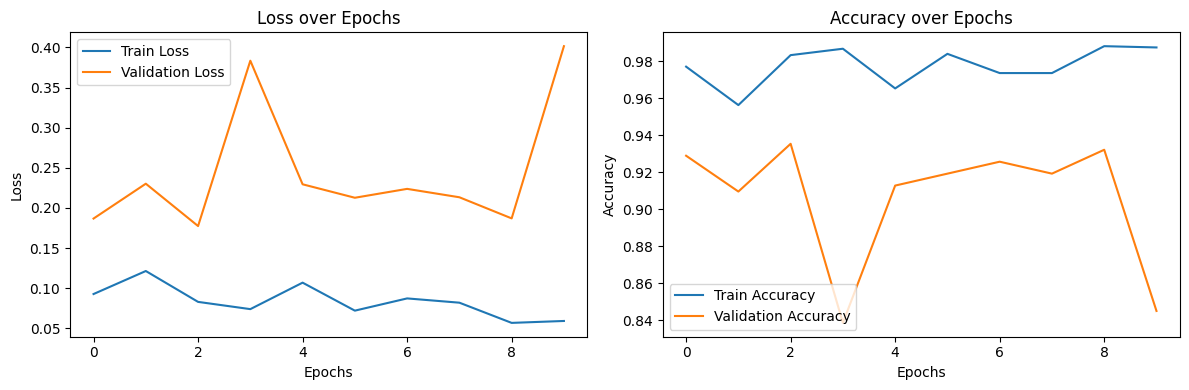

In [103]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Extracting metrics
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']  # Change 'acc' to 'accuracy'
    val_acc = history.history['val_accuracy']  # Change 'val_acc' to 'val_accuracy'
    
    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss Plot
    ax1.plot(train_loss, label='Train Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2.plot(train_acc, label='Train Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Call the function after training
plot_metrics(history)


# Results

### Feature Extraction

In [101]:
import os
from keras.models import Model
from keras.layers import Flatten, Dense
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

def create_feature_extractor(model, layer_name):
    """
    Create a feature extraction model from the given layer name.
    
    Arguments:
        model: The original model from which to extract features.
        layer_name: The name of the layer to extract features from.
    
    Returns:
        feature_extractor: A Keras Model object for feature extraction.
    """
    # Get the specified layer
    layer = model.get_layer(layer_name)
    feature_extractor = Model(inputs=model.input, outputs=layer.output, name='FeatureExtractor')
    return feature_extractor

# Function to preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(240, 240))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

# Example usage
layer_name = 'conv0'  # Change to the desired layer name
fcn_model = model
feature_extractor = create_feature_extractor(fcn_model, layer_name)

# Create a new classification model using the feature extractor
x = Flatten()(feature_extractor.output)  # Flatten the features
x = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (tumor/no tumor)
classification_model = Model(inputs=feature_extractor.input, outputs=x)

# Specify the directory containing images
image_folder_yes = '/Users/akashthakkar/Desktop/Brain Tumuour/augmented data/yes/'  # Change to your folder path
image_folder_no = '/Users/akashthakkar/Desktop/Brain Tumuour/augmented data/no/'  # Change to your folder path

# Function to predict tumor presence
def predict_tumor(image_folder):
    for image_name in os.listdir(image_folder):
        # Construct full image path
        image_path = os.path.join(image_folder, image_name)
        
        # Ensure it's a file (to skip directories)
        if os.path.isfile(image_path):
            # Load and preprocess the image
            processed_image = preprocess_image(image_path)

            # Get the prediction from the classification model
            prediction = classification_model.predict(processed_image)

            # Interpret the prediction
            predicted_value = prediction[0][0]  # Get the predicted probability
            if predicted_value >= 0.5:
                label = "Tumor"
            else:
                label = "No Tumor"

            # Print the image name, predicted value, and label
            print(f"Image: {image_name}, Predicted Value: {predicted_value:.4f}, Prediction: {label}")

# Predict for both folders
print("Predictions for images in the 'yes' folder:")
predict_tumor(image_folder_yes)

print("\nPredictions for images in the 'no' folder:")
predict_tumor(image_folder_no)


Predictions for images in the 'yes' folder:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Image: aug_Y100_0_4855.jpg, Predicted Value: 0.5465, Prediction: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: aug_Y254_0_4212.jpg, Predicted Value: 0.5057, Prediction: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Image: aug_Y37_0_9694.jpg, Predicted Value: 0.2687, Prediction: No Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Image: aug_Y243_0_9105.jpg, Predicted Value: 0.5399, Prediction: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: aug_Y106_0_2432.jpg, Predicted Value: 0.3118, Prediction: No Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image: aug_Y154_0_1160.jpg, Predicted Value: 0.4135, Prediction: No Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: aug_Y82_0_3407.jpg, Predicted Value: 0.4666, Prediction: No Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: aug_Y117_0_9217.jpg, Predicted Value: 0.5043, Prediction: Tumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: aug_Y159_0_2278.jpg, Predicte